# PCA Parameter Optimisation
TL Mar 2019

In [1]:
%load_ext autoreload
%autoreload 2

from pipe import getdata
from pandas.tseries.offsets import BDay

from IPython.core.debugger import Tracer #pdb.set_trace()
import pdb

import statsmodels.tsa.stattools as ts

import random
import time
from itertools import compress
from sklearn.decomposition import PCA

Certain modules were not found which will affect which functions will work. Check if you have OneTick installed and module NumPy_OneTickQuery not found. Also check for win32com which might not work on Linux machines (untested)


Q:\wp\python-3.6.2.amd64\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
## Import data from csv files ##

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

def csv2df(csvName):
    
    # Import and format CSV as df
    # See spotEUR.csv for formatting template
    
    dfOut = pd.read_csv(csvName, parse_dates=[0],
                        infer_datetime_format=True, dayfirst=True)
    
    dfOut['Date'] = pd.to_datetime(dfOut['Date'])
    dfOut.set_index('Date', inplace=True)
    dfOut = dfOut.sort_index() # Sort chronologically
    
    return dfOut

In [3]:
## Stat analysis functions ##

def runStats(dfInput, nCol):
    
    dfRets = dfInput.diff()*100 # Daily returns in bps
    dfRets = dfRets.dropna() # First row is NaN, gets dropped, any others too
    
    colNames = dfRets.columns.get_values()
    colNames[nCol]
    
    retRange = dfRets[colNames[nCol]].max()-dfRets[colNames[nCol]].min()

    dfRets[colNames[nCol]].plot(kind='hist',bins=int(retRange),title=colNames[nCol])
    
    return print(colNames[nCol],"\n",
                 'range',retRange,"\n",
                 'mean',np.round(dfRets[colNames[nCol]].mean(),3),"\n",
                 'sigma',np.round(dfRets[colNames[nCol]].std(),3))

In [4]:
## PC Analysis (rolling window) ##

def pcaRun(dfPar):
    
    dfRets = dfPar.diff()*100 # Daily returns in bps
    dfRets = dfRets.dropna() # First row is NaN, gets dropped, any others too
    
    from scipy import stats
    dfRets_o = dfRets[(np.abs(stats.zscore(dfRets)) < 3).all(axis=1)] # Remove 3 sigma outliers
    
    cols = dfRets_o.shape[1]
    pca = PCA(n_components=cols)
    
    eigenVal = []
    eigenVec = []

    sampleSize = dfRets_o.shape[0]
    lookbackSize = 90
    
    for i in range(0,(sampleSize-lookbackSize)):
        #print(i,lookbackSize+i)
        pca.fit(dfRets_o.iloc[i:lookbackSize+i])
        eigenVal.append(pca.explained_variance_ratio_)
        eigenVec.append(pca.components_)
        
    dfPC1 = pd.DataFrame().reindex_like(dfRets_o)
    dfPC1 = dfPC1.iloc[lookbackSize:]
    
    for n in range(0,len(eigenVec)):
        for k in range(0,len(eigenVec[0][0])):
            dfPC1.iloc[n,k] = np.abs(eigenVec[n][0][k])
        
    return dfPC1

def pcaPlot(dfLoad, nDays, firstTenor=0, lastTenor='', mySize=(14,10)):
    
    if lastTenor=='':
        lastTenor = dfLoad.shape[1]
    
    return dfLoad.iloc[dfLoad.shape[0]-nDays:,
                       firstTenor:lastTenor].plot(legend=True,
                                                  figsize=mySize,
                                                  grid=True,
                                                  colormap='rainbow')

In [5]:
## Time series plotting functions ##

def curvePlot(dfInput, nDays, sLong, sShort, mySize=(14,5)):
    
    dfSpread = pd.DataFrame()
    dfSpread = (dfInput[sLong + ' Par Swap Rate']-dfInput[sShort + ' Par Swap Rate'])*100
    
    axSpread = dfSpread.iloc[dfSpread.shape[0]-nDays:].plot(legend=False,
                                                            figsize=mySize,
                                                            title='Curve '+sShort+'/'+sLong,
                                                            grid=True)
    return axSpread

def flyPlot(dfInput, nDays, wing1, belly, wing2, mySize=(14,5)):
    
    dfFly = pd.DataFrame()
    dfFly = ((2*dfInput[belly + ' Par Swap Rate'])
             -dfInput[wing1 + ' Par Swap Rate']
             -dfInput[wing2 + ' Par Swap Rate'])*100
    
    axFly = dfFly.iloc[dfSpread.shape[0]-nDays:].plot(legend=False,
                                                      figsize=mySize,
                                                      title='Fly '+wing1+'/'+belly+'/'+wing2,
                                                      grid=True)
    return axFly

In [6]:
## Column renaming function ##

def renameCol(dfInput,removeString=' Fwd Swap Rate'):
    
    test = dfInput.columns.get_values()
    
    for x in range(0,len(test)):
        test[x] = test[x].replace(removeString,'')
        
    dfInput.columns = test
    
    return dfInput

In [7]:
from sklearn.decomposition import PCA

def pcaRes(dfCross,trainSize,testSize):
    
    pca = PCA(n_components=3) #n_components=3
    
    m = trainSize # training set size
    n = testSize # test set size
    
    trainSet = dfCross.iloc[dfCross.shape[0]-n-m:dfCross.shape[0]-n] # Need a way to loop thru the entire sample
    testSet = dfCross.iloc[dfCross.shape[0]-n:]
    
    # Train model
    pca.fit(trainSet)

    # Regen rates from model both in and out of sample
    inSample = pca.transform(trainSet)
    outSample = pca.transform(testSet) #pd.DataFrame(pca.transform(testSet)).set_index(testSet.index)
    
    inRes = trainSet - pca.inverse_transform(inSample)
    outRes = testSet - pca.inverse_transform(outSample)
    
    return inRes, outRes

In [8]:
from sklearn.linear_model import LinearRegression

def costSlope(dfInput,plot=False):
    
    model = LinearRegression(fit_intercept=True)
    
    cols = dfInput.columns.get_values()
    x = np.arange(dfInput.shape[0])
    slope = []
    cost = []
    
    for i in range(0,dfInput.shape[1]):
        
        y = dfInput[cols[i]].values
        
        model.fit(x[:, np.newaxis], y)
        xfit = np.linspace(0, dfInput.shape[0], 1000)
        yfit = model.predict(xfit[:, np.newaxis])
        
        slope.append(model.coef_[0])
        cost.append(np.round(np.abs(model.coef_[0])-0.01,5))
               
        if plot==True:
            plt.scatter(x, y)
            plt.plot(xfit, yfit)
        
    return slope, cost

5Y EUR/USD Basis Swap Spread 
 range 812.49 
 mean 0.453 
 sigma 77.6


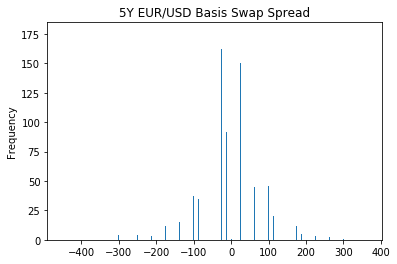

In [12]:
## Check data

dfdummy = csv2df('eurusdPar.csv')

from scipy import stats
dfdumdum = dfdummy[(np.abs(stats.zscore(dfdummy)) < 3).all(axis=1)]

runStats(dfdumdum,9)

plt.show()

In [9]:
# Data import
dfTest = renameCol(csv2df('eurusdFwdnew.csv'),' Basis Fwd Swap Spread')
dfTest = dfTest.dropna()

In [10]:
## PCA param optimization

training = np.arange(200)
test = np.arange(60)

outCost = np.random.rand(len(training),len(test))

#dfOut = pd.DataFrame({'trainSize':[],'testSize':[],'Cost':[]})

for i in range(3,len(training)):
    
    for j in range(1,len(test)):
        
        myRes = pcaRes(dfTest,training[i],test[j])
        outCost[i,j] = (np.mean(costSlope(myRes[1])[1]))
        #outCost.append(np.mean(costSlope(myRes[1])[1]))

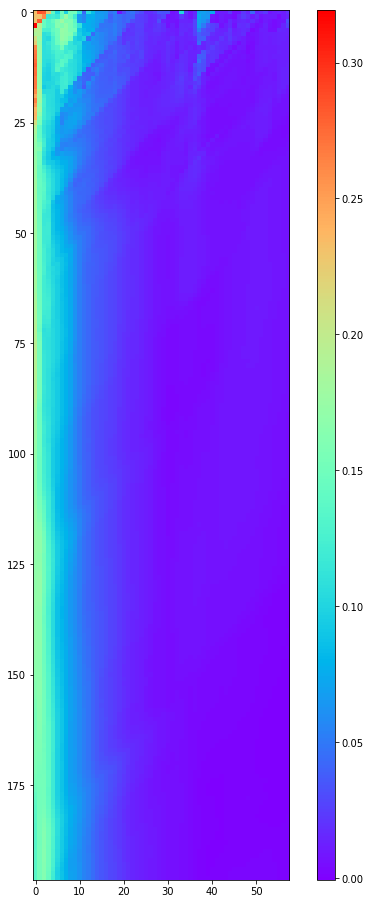

In [40]:
fig = plt.figure(figsize=(10,16))
plt.imshow(outCost[3:,2:], cmap='rainbow')
plt.colorbar(shrink=1, aspect=50)
plt.show()

-0.006936
0.006035


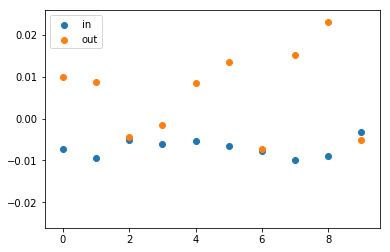

In [34]:
inSlope, inCost = costSlope(inRes)
outSlope, outCost = costSlope(resid)

print(np.mean(inCost))
print(np.mean(outCost))

plt.scatter(np.arange(len(inCost)),inCost,label='in')
plt.scatter(np.arange(len(outCost)),outCost,label='out')
plt.legend(loc='best')
plt.show()

In [25]:
### In sample residual stats ###

inRes # In sample residuals

cols = inRes.columns.get_values()
n = 1
inRes[cols[n]].plot(kind='hist',bins=15,title=cols[n])
#plt.show()

from scipy import stats

cols = inRes.columns.get_values()
tstat = []
pval = []

# Import the Time Series library
import statsmodels.tsa.stattools as ts

# Output the results of the Augmented Dickey-Fuller test for Google
# with a lag order value of 1

lag = 10 # Time ranges to consider 1,2,3,5,10,20,30

for i in range(0,inRes.shape[1]):
    
    print(cols[i],'w/ lag of',lag)
    
    tstat.append(stats.shapiro(inRes[cols[i]].values)[0])
    pval.append(stats.shapiro(inRes[cols[i]].values)[1])
    print('Normality',stats.shapiro(inRes[cols[i]].values)[1]>0.05) #Null accepted if p>0.05 and if Normal
    print('Mean',np.round(np.mean(inRes[cols[i]]),5))
    print('pval',stats.shapiro(inRes[cols[i]].values)[1])
    
    print('Mean rev likely @ 5% c.l.',ts.adfuller(inRes[cols[i]], lag)[1]<0.05,'\n')

1Y X 1Y EUR/USD w/ lag of 10
Normality True
Mean 0.0
pval 0.6202765703201294
Mean rev likely @ 5% c.l. True 

2Y X 1Y EUR/USD w/ lag of 10
Normality True
Mean -0.0
pval 0.5771496891975403
Mean rev likely @ 5% c.l. True 

3Y X 1Y EUR/USD w/ lag of 10
Normality True
Mean -0.0
pval 0.2368571013212204
Mean rev likely @ 5% c.l. True 

5Y X 5Y EUR/USD w/ lag of 10
Normality False
Mean 0.0
pval 0.00032735575223341584
Mean rev likely @ 5% c.l. True 

10Y X 2Y EUR/USD w/ lag of 10
Normality False
Mean 0.0
pval 0.027401935309171677
Mean rev likely @ 5% c.l. True 

12Y X 3Y EUR/USD w/ lag of 10
Normality False
Mean 0.0
pval 1.4705763078382006e-06
Mean rev likely @ 5% c.l. False 

15Y X 5Y EUR/USD w/ lag of 10
Normality True
Mean -0.0
pval 0.2291952669620514
Mean rev likely @ 5% c.l. False 

20Y X 5Y EUR/USD w/ lag of 10
Normality False
Mean -0.0
pval 2.4876905868609356e-08
Mean rev likely @ 5% c.l. False 

25Y X 5Y EUR/USD w/ lag of 10
Normality False
Mean 0.0
pval 0.005125352647155523
Mean rev l

In [26]:
### Out of sample residual stats ###
cols = resid.columns.get_values()
n = 1
resid[cols[n]].plot(kind='hist',bins=15,title=cols[n])
#plt.show()

from scipy import stats

cols = resid.columns.get_values()
tstat = []
pval = []

# Import the Time Series library
import statsmodels.tsa.stattools as ts

# Output the results of the Augmented Dickey-Fuller test for Google
# with a lag order value of 1

lag = 10

for i in range(0,resid.shape[1]):
    
    print(cols[i],'w/ lag of',lag)
    
    tstat.append(stats.shapiro(resid[cols[i]].values)[0])
    pval.append(stats.shapiro(resid[cols[i]].values)[1])
    print('Normality',stats.shapiro(resid[cols[i]].values)[1]>0.05) #Null accepted if p>0.05 and if Normal
    print('Mean',np.round(np.mean(resid[cols[i]]),5))
    print('pval',stats.shapiro(resid[cols[i]].values)[1])
    
    print('Mean rev likely @ 5% c.l.',ts.adfuller(resid[cols[i]], lag)[1]<0.05,'\n')

# Notes of ADF test for mean reversion

# The first value is the calculated test-statistic, while the second value is the p-value. 
# The fourth is the number of data points in the sample. 
# The fifth value, the dictionary, contains the critical values of the test-statistic 
# at the 1, 5 and 10 percent values respectively.

# Since the calculated value of the test statistic is *larger* than any of the critical values 
# at the 1, 5 or 10 percent levels, we cannot reject the null hypothesis of γ=0 and thus we 
# are *unlikely* to have found a mean reverting time series.

1Y X 1Y EUR/USD w/ lag of 10
Normality True
Mean 0.16032
pval 0.5269463062286377
Mean rev likely @ 5% c.l. True 

2Y X 1Y EUR/USD w/ lag of 10
Normality True
Mean -0.02266
pval 0.12286169826984406
Mean rev likely @ 5% c.l. True 

3Y X 1Y EUR/USD w/ lag of 10
Normality True
Mean -0.15357
pval 0.10777092725038528
Mean rev likely @ 5% c.l. True 

5Y X 5Y EUR/USD w/ lag of 10
Normality False
Mean -0.46891
pval 0.003395246574655175
Mean rev likely @ 5% c.l. False 

10Y X 2Y EUR/USD w/ lag of 10
Normality False
Mean -0.10178
pval 0.00010490295971976593
Mean rev likely @ 5% c.l. False 

12Y X 3Y EUR/USD w/ lag of 10
Normality True
Mean -1.06956
pval 0.061536502093076706
Mean rev likely @ 5% c.l. True 

15Y X 5Y EUR/USD w/ lag of 10
Normality False
Mean -0.20998
pval 0.004768588580191135
Mean rev likely @ 5% c.l. False 

20Y X 5Y EUR/USD w/ lag of 10
Normality True
Mean -0.16551
pval 0.07175207883119583
Mean rev likely @ 5% c.l. True 

25Y X 5Y EUR/USD w/ lag of 10
Normality False
Mean 0.54032